In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from aeon.datasets import load_classification
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

# --- DEFINE YOUR CUSTOM DISTANCE (PSDTW) ---
def psdtw(x, y):
    x_1d = x.squeeze()
    y_1d = y.squeeze()
    # Placeholder logic
    return np.linalg.norm(x_1d - y_1d)

In [2]:
# 1. Define the Datasets to Test
# These are all standard UCR/UEA datasets supported by Aeon.
# They will download automatically if you don't have them.
dataset_names = [
    "ItalyPowerDemand",  # Small, Power usage
    "ArrowHead",         # Shape classification
    "GunPoint",          # Motion classification (very popular)
    "Coffee",            # Spectrographic data
    "Plane"              # Shape classification
]

# 2. Define the Metrics to Test
methods = [
    {"name": "Euclidean", "metric": "euclidean", "params": {}},
    {"name": "DTW",       "metric": "dtw",       "params": {"window": 0.1}},
    {"name": "PSDTW",     "metric": psdtw,       "params": {}}  # Your custom function
]

results = []

print(f"{'Dataset':<20} | {'Method':<15} | {'Acc':<8} | {'Time':<8}")
print("-" * 60)

# --- OUTER LOOP: Iterate over Datasets ---
for d_name in dataset_names:
    
    # Load data once per dataset
    try:
        X_train, y_train = load_classification(d_name, split="train")
        X_test, y_test = load_classification(d_name, split="test")
    except Exception as e:
        print(f"Error loading {d_name}: {e}")
        continue

    # --- INNER LOOP: Iterate over Methods ---
    for method in methods:
        m_name = method["name"]
        metric = method["metric"]
        params = method["params"]
        
        # Initialize Classifier
        clf = KNeighborsTimeSeriesClassifier(
            n_neighbors=1, 
            distance=metric, 
            distance_params=params
        )
        
        # Train & Predict
        start = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        elapsed = time.time() - start
        
        # Record Score
        acc = accuracy_score(y_test, y_pred)
        
        # Print progress as we go
        print(f"{d_name:<20} | {m_name:<15} | {acc:.4f}   | {elapsed:.2f}s")
        
        # Store for final table
        results.append({
            "Dataset": d_name,
            "Method": m_name,
            "Accuracy": acc,
            "Time (s)": elapsed
        })

print("-" * 60)
print("Benchmarking Complete.")

Dataset              | Method          | Acc      | Time    
------------------------------------------------------------


/csproject/kdd/cyuab2/miniconda3/envs/ksfdtw/lib/python3.12/site-packages/aeon/distances/pointwise/_euclidean.py:173: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  distances[i, j] = euclidean_distance(x[i], y[j])


ItalyPowerDemand     | Euclidean       | 0.9553   | 2.14s
ItalyPowerDemand     | DTW             | 0.9524   | 1.83s
ItalyPowerDemand     | PSDTW           | 0.9553   | 0.75s
ArrowHead            | Euclidean       | 0.8000   | 0.00s
ArrowHead            | DTW             | 0.7200   | 0.69s
ArrowHead            | PSDTW           | 0.8000   | 0.06s
GunPoint             | Euclidean       | 0.9133   | 0.00s
GunPoint             | DTW             | 0.9400   | 0.29s
GunPoint             | PSDTW           | 0.9133   | 0.07s
Coffee               | Euclidean       | 1.0000   | 0.00s
Coffee               | DTW             | 1.0000   | 0.11s
Coffee               | PSDTW           | 1.0000   | 0.01s
Plane                | Euclidean       | 0.9619   | 0.00s
Plane                | DTW             | 1.0000   | 0.39s
Plane                | PSDTW           | 0.9619   | 0.10s
------------------------------------------------------------
Benchmarking Complete.



Summary Table (Accuracy):


Method,DTW,Euclidean,PSDTW
Dataset,,,
ArrowHead,0.720000,0.800000,0.800000
Coffee,1.000000,1.000000,1.000000
GunPoint,0.940000,0.913333,0.913333
ItalyPowerDemand,0.952381,0.955296,0.955296
Plane,1.000000,0.961905,0.961905
Average,0.922476,0.926107,0.926107


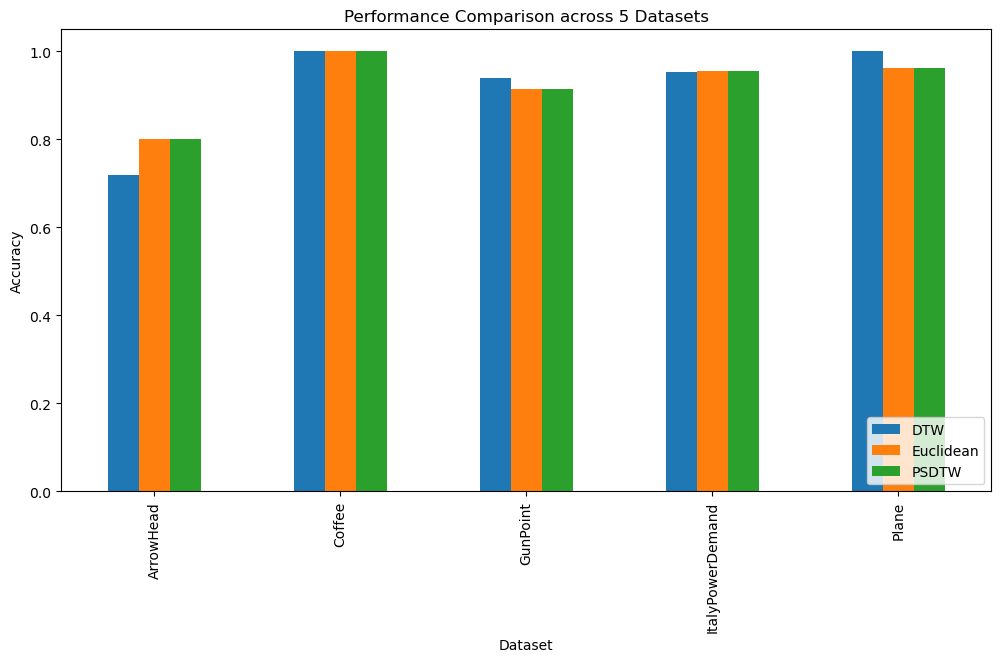

In [3]:
# Convert results to DataFrame
df = pd.DataFrame(results)

# Create a pivot table: Rows=Datasets, Columns=Methods, Values=Accuracy
pivot_table = df.pivot(index="Dataset", columns="Method", values="Accuracy")

# Calculate average rank or average accuracy to see who 'won'
pivot_table.loc['Average'] = pivot_table.mean()

print("\nSummary Table (Accuracy):")
display(pivot_table) # Use print(pivot_table) if not in Jupyter

# Optional: Plotting
pivot_table.drop('Average').plot(kind='bar', figsize=(12, 6))
plt.ylabel("Accuracy")
plt.title("Performance Comparison across 5 Datasets")
plt.legend(loc='lower right')
plt.show()

In [4]:
# Assuming 'pivot_table' is the DataFrame created in the previous step

# 1. Generate LaTeX
latex_code = pivot_table.to_latex(
    float_format="%.3f",  # Limit to 3 decimal places
    caption="Comparison of Accuracy across 5 Datasets",
    label="tab:accuracy_comparison"
)

print(latex_code)

\begin{table}
\caption{Comparison of Accuracy across 5 Datasets}
\label{tab:accuracy_comparison}
\begin{tabular}{lrrr}
\toprule
Method & DTW & Euclidean & PSDTW \\
Dataset &  &  &  \\
\midrule
ArrowHead & 0.720 & 0.800 & 0.800 \\
Coffee & 1.000 & 1.000 & 1.000 \\
GunPoint & 0.940 & 0.913 & 0.913 \\
ItalyPowerDemand & 0.952 & 0.955 & 0.955 \\
Plane & 1.000 & 0.962 & 0.962 \\
Average & 0.922 & 0.926 & 0.926 \\
\bottomrule
\end{tabular}
\end{table}



In [5]:
# 1. Define a function to bold the maximum value in a row
def bold_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# 2. Apply style and convert to LaTeX
styled_latex = pivot_table.style \
    .format(precision=3) \
    .highlight_max(axis=1, props="textbf:--rwrap;") \
    .to_latex(
        caption="Accuracy Comparison (Best method in bold)",
        label="tab:results",
        hrules=True,       # Adds nicer horizontal lines (requires booktabs)
        column_format="l" + "c"*len(pivot_table.columns) # Align: Left for names, Center for data
    )

print(styled_latex)

\begin{table}
\caption{Accuracy Comparison (Best method in bold)}
\label{tab:results}
\begin{tabular}{lccc}
\toprule
Method & DTW & Euclidean & PSDTW \\
Dataset &  &  &  \\
\midrule
ArrowHead & 0.720 & \textbf{0.800} & \textbf{0.800} \\
Coffee & \textbf{1.000} & \textbf{1.000} & \textbf{1.000} \\
GunPoint & \textbf{0.940} & 0.913 & 0.913 \\
ItalyPowerDemand & 0.952 & \textbf{0.955} & \textbf{0.955} \\
Plane & \textbf{1.000} & 0.962 & 0.962 \\
Average & 0.922 & \textbf{0.926} & \textbf{0.926} \\
\bottomrule
\end{tabular}
\end{table}



In [6]:
print("\n--- LaTeX Output ---")

# Option A: Simple
# print(pivot_table.to_latex(float_format="%.3f"))

# Option B: Professional (Bold Max)
# Note: 'props="textbf:--rwrap;"' wraps the value in \textbf{}
latex_output = pivot_table.style \
    .format(precision=3) \
    .highlight_max(axis=1, props="textbf:--rwrap;") \
    .to_latex(hrules=True, caption="Benchmark Results", label="tab:benchmarks")

print(latex_output)


--- LaTeX Output ---
\begin{table}
\caption{Benchmark Results}
\label{tab:benchmarks}
\begin{tabular}{lrrr}
\toprule
Method & DTW & Euclidean & PSDTW \\
Dataset &  &  &  \\
\midrule
ArrowHead & 0.720 & \textbf{0.800} & \textbf{0.800} \\
Coffee & \textbf{1.000} & \textbf{1.000} & \textbf{1.000} \\
GunPoint & \textbf{0.940} & 0.913 & 0.913 \\
ItalyPowerDemand & 0.952 & \textbf{0.955} & \textbf{0.955} \\
Plane & \textbf{1.000} & 0.962 & 0.962 \\
Average & 0.922 & \textbf{0.926} & \textbf{0.926} \\
\bottomrule
\end{tabular}
\end{table}

